<a href="https://colab.research.google.com/github/660710078/TopGun2025/blob/main/Image_Processing_OpenCV_test_stand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing — OpenCV

**เนื้อหา**:
- การโหลด/แสดงภาพอย่างถูกสี (BGR→RGB)
- การใช้ **HSV** เพื่อสร้าง **Sky Mask** (โทนฟ้า + เมฆขาว)
- **Morphological Operations** (erode, open/close) ทำความสะอาด mask
- **Black-hat** เพื่อเน้นโดรน (วัตถุสีเข้มบนท้องฟ้าที่สว่าง)
- **Threshold + Contour Filtering**

> วางไฟล์ภาพชื่อ `images/drones.jpg` ไว้ในโฟลเดอร์เดียวกับโน้ตบุ๊กนี้


In [ ]:
!pip install requests

In [ ]:
## Download image to directory
import requests  ##ใช้ในการส่ง HTTP requests ไปยังเว็บไซต์ เช่น การดาวน์โหลดไฟล์จาก URL
import os  ##ใช้จัดการกับ ไฟล์และโฟลเดอร์ในระบบปฏิบัติการ (เช่น สร้างโฟลเดอร์, ตรวจสอบเส้นทาง)

# URL ของภาพ
url = "https://aviationweek.com/sites/default/files/2022-11/drones-during-todays-pilot-2.jpg"

# สร้างโฟลเดอร์ images ถ้ายังไม่มี
os.makedirs("images", exist_ok=True)

# กำหนดชื่อไฟล์ปลายทาง
filename = "images/drones.jpg"

# ดาวน์โหลดและบันทึก
response = requests.get(url)
if response.status_code == 200:
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"Downloaded to {filename}")
else:
    print(f"Failed to download (status code {response.status_code})")


Downloaded to images/drones.jpg


In [ ]:

from PIL import Image

image_path = "/content/Test1/1.JPEG"

# เปิดภาพ
img = Image.open(image_path)

# แสดงภาพ
img.show()

# # แสดงขนาดภาพ
# print("Image size:", img.size)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Test1/1.JPEG'

## ติดตั้ง/นำเข้าไลบรารีที่ต้องใช้
- `opencv-python` (`cv2`)
- `numpy`
- `matplotlib`


In [ ]:
# !pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ตั้งค่าการแสดงผล matplotlib
%matplotlib inline


## 1. โหลดและแสดงภาพ (BGR→RGB)
- OpenCV อ่านภาพเป็น **BGR** (Blue-Green-Red)
- Matplotlib แสดงภาพเป็น **RGB**: ต้องแปลง BGR → RGB เพื่อแสดงผล


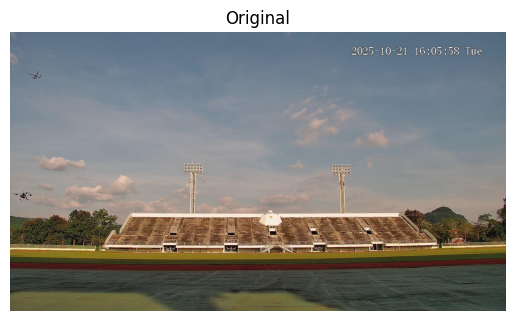

In [ ]:
# โหลดภาพ ใช้ OpenCV (cv2) อ่านไฟล์ภาพจาก path ที่กำหนด
# อ่านภาพในรูปแบบ BGR (Blue–Green–Red)
bgr = cv2.imread("/content/test.jpg")

# แปลงเป็น BGR → RGB เพื่อให้แสดงสีถูกต้อง
# ฟังก์ชัน cv2.cvtColor() ใช้แปลงลำดับช่องสีให้ถูกต้อง
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# แสดงผล
# imshow() ใช้แสดง array ของภาพ (ต้องเป็น RGB)
plt.imshow(rgb); plt.axis('off')
plt.title("Original")
plt.show()


## 2.HSV + สร้าง **Sky Mask** (ท้องฟ้า + เมฆ)
- HSV (Hue, Saturation, Value) เหมาะกับการแยกสีตาม “ลักษณะของแสง” มากกว่า
- แปลง BGR → HSV
- เลือกช่วง **H,S,V** ที่แทนท้องฟ้าและเมฆ
  - ฟ้า: `H≈90–135`, `S≥0`, `V≥80` (ปรับได้ตามแสง)
  - เมฆ: `S≤35`, `V≥180`
- แยกภาพออกเป็น 3 channel (แต่ละ channel คือภาพขาวดำ 1 แผ่น):

H → เฉดสี

S → ความสด

V → ความสว่าง



- เลือกเฉดสี ฟ้า ซึ่งใน HSV มีค่า H ประมาณ 90–135

ค่า S≥0 หมายถึงไม่จำกัดความสด (ฟ้าอ่อนหรือเข้มก็ได้)

ค่า V≥80 หมายถึงบริเวณที่สว่างพอ (ท้องฟ้ามักไม่มืด)

- เมฆมักจะมีสี “จืด” (S ต่ำ) และ “สว่างมาก” (V สูง)

ค่า S ≤ 35 → สีไม่สด (เกือบขาว)

ค่า V ≥ 180 → สว่างมาก (เกือบขาว)

- | = OR → รวมทั้งท้องฟ้าและเมฆเข้าด้วยกัน .astype(np.uint8) → แปลงจาก True/False เป็นค่าตัวเลข (0 หรือ 1)

* 255 → ทำให้ mask เป็นรูปภาพขาวดำ:

    - 0 = ไม่ใช่ท้องฟ้า

    - 255 = คือท้องฟ้าหรือเมฆ


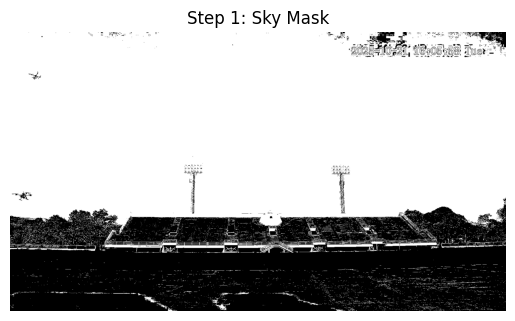

In [ ]:
# สร้าง mask เฉพาะบริเวณท้องฟ้า/เมฆ
# แปลง BGR → HSV
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(hsv) # แยกภาพออกเป็น 3 channel

# เงื่อนไขแยกท้องฟ้า (สีฟ้า)
blue_sky = (H>=0) & (H<=180) & (S>=0) & (S<=85) & (V>=91) & (V<=255)
# clouds   = (S<=2) & (V>=58)
# รวมทั้งท้องฟ้าและเมฆเข้าด้วยกัน
sky_mask = (blue_sky ).astype(np.uint8) * 255

# blue_sky = (H>=90) & (H<=135) & (S>=0) & (V>=80)
# clouds   = (S<=35) & (V>=180)
# sky_mask = (blue_sky | clouds).astype(np.uint8) * 255

# แสดงผล mask
plt.imshow(sky_mask, cmap='gray'); plt.axis('off'); plt.title("Step 1: Sky Mask"); plt.show()


## 3. ทำความสะอาด Mask ด้วย Morphology
- คือการ “ปรับรูปร่าง” ของวัตถุในภาพ (โดยเฉพาะภาพ mask แบบขาวดำ)
ใช้กันมากในการ ลบ noise, เชื่อมรูช่องว่าง, ทำให้เส้นหนาขึ้นหรือบางลง
- **Erode** เพื่อลดเศษเล็ก ๆ ที่ไม่ใช่ท้องฟ้า cv2.erode() → กัดเซาะ (ทำให้วัตถุบางลง)
    - หน้าที่:
      - ลบ “เศษเล็ก ๆ” ที่ไม่ใช่ท้องฟ้าออกไป
      - ทำให้บริเวณขอบท้องฟ้าบางลง (คล้าย ๆ การหดตัวของพื้นที่สีขาว)
    
    - การทำงาน:
      - พิจารณา pixel ทุกจุดใน mask ถ้าภายในกรอบ 5×5 มี pixel สีดำแม้แต่จุดเดียว → pixel กลางจะกลายเป็นดำ

    - ผลลัพธ์:
      - จุดสีขาวขนาดเล็ก ๆ ที่หลุดอยู่รอบ ๆ ท้องฟ้าจะหายไป ท้องฟ้าหดลงเล็กน้อยแต่สะอาดขึ้น
- **Close** เติมช่องว่างภายในท้องฟ้า cv2.dilate() → ขยาย (ทำให้วัตถุหนาขึ้น)
- **Open** ลบ noise ขาวเล็ก ๆ ที่ยังเหลือ cv2.morphologyEx() → รวมขั้นตอน (เช่น Opening, Closing)
> ควรเลือก kernel ใหญ่พอเพื่อให้บริเวณท้องฟ้าดูเรียบและต่อเนื่อง


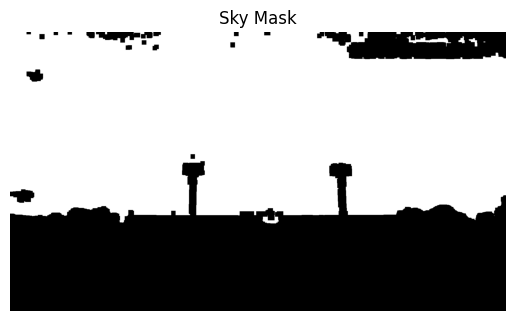

In [ ]:
kernel = np.ones((5,5), np.uint8)

sky_mask = cv2.erode(sky_mask, kernel, iterations=4)
# iterations=8 หมายถึงทำซ้ำ 8 ครั้ง → กัดมาก ถ้าแรงเกินไปลดเป็น 2–4

plt.imshow(sky_mask, cmap='gray'); plt.axis('off'); plt.title("Sky Mask"); plt.show()

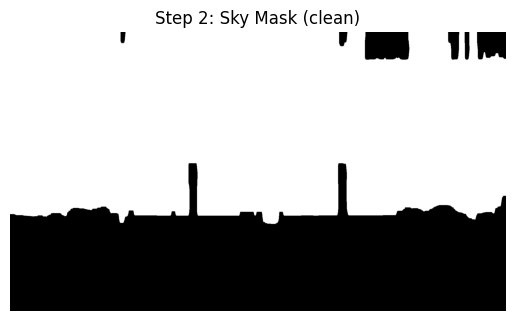

In [ ]:
# ใช้โครงสร้างวงรีขนาดใหญ่เพื่อ close/open
kernel_big = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,80))
sky_mask = cv2.morphologyEx(sky_mask, cv2.MORPH_CLOSE, kernel_big)
sky_mask = cv2.morphologyEx(sky_mask, cv2.MORPH_OPEN,  kernel_big)

plt.imshow(sky_mask, cmap='gray'); plt.axis('off'); plt.title("Step 2: Sky Mask (clean)"); plt.show()


## 4. แยกภูเขา/พื้นดิน และเก็บเฉพาะท้องฟ้า
- **Mountains/Ground Mask** = not sky
- **Sky Only** = ใช้ mask เพื่อเก็บเฉพาะพิกเซลท้องฟ้า


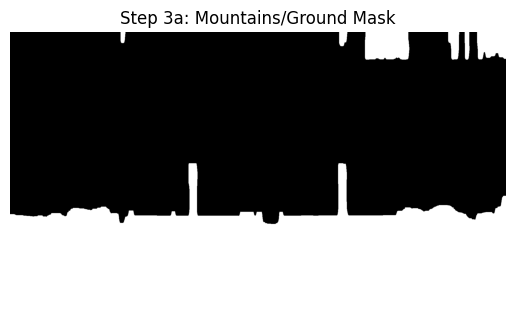

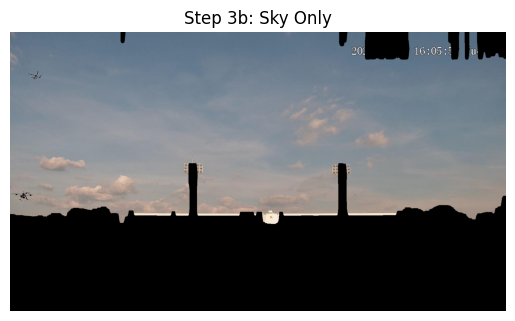

In [ ]:
mountain_mask = cv2.bitwise_not(sky_mask)
plt.imshow(mountain_mask, cmap='gray'); plt.axis('off'); plt.title("Step 3a: Mountains/Ground Mask"); plt.show()

sky_only = cv2.bitwise_and(rgb, rgb, mask=sky_mask)
plt.imshow(sky_only); plt.axis('off'); plt.title("Step 3b: Sky Only"); plt.show()


## 5. Black-hat — เน้นวัตถุสีมืดเล็ก ๆ บนท้องฟ้าที่สว่าง
- **MORPH_BLACKHAT** ช่วยดึงส่วนที่ **มืดกว่าพื้นหลัง** ออกมา
- เหมาะกับโดรนเล็ก ๆ บนท้องฟ้า


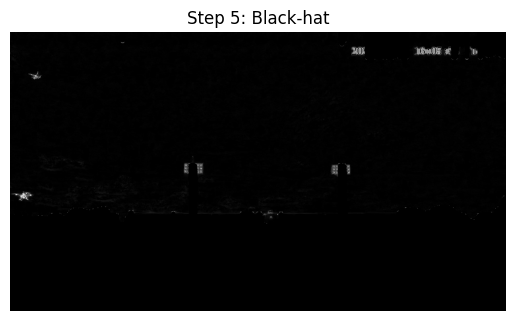

In [ ]:
gray = cv2.cvtColor(sky_only, cv2.COLOR_RGB2GRAY)
kernel_bh = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel_bh)

plt.imshow(blackhat, cmap='gray'); plt.axis('off'); plt.title("Step 5: Black-hat"); plt.show()


## 6. ขยายสัญญาณด้วย Dilate
- ขยายจุดมืดที่ตรวจพบบน black-hat ให้ใหญ่ขึ้นเพื่อผ่านเกณฑ์พื้นที่ขั้นต่ำ


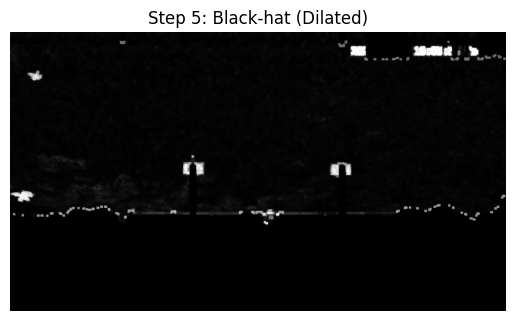

In [ ]:
kernel_d = np.ones((5,5), np.uint8)
blackhat_d = cv2.dilate(blackhat, kernel_d, iterations=2)

plt.imshow(blackhat_d, cmap='gray'); plt.axis('off'); plt.title("Step 5: Black-hat (Dilated)"); plt.show()


## 7. Threshold + เปิดรูเล็ก ๆ (Open) → Candidate Mask
- ใช้ **Otsu** เพื่อเลือก threshold อัตโนมัติ
- ใช้ **Open (3×3)** เพื่อลบ noise จิ๋ว


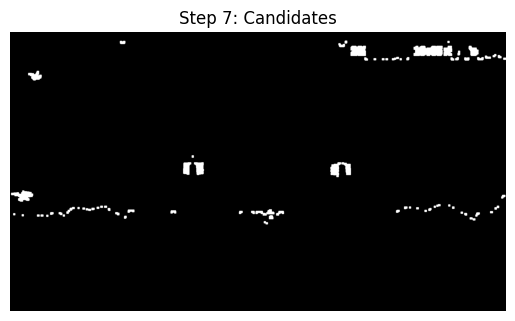

In [ ]:
_, cand = cv2.threshold(blackhat_d, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cand = cv2.morphologyEx(cand, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))

plt.imshow(cand, cmap='gray'); plt.axis('off'); plt.title("Step 7: Candidates"); plt.show()


## 8. Contour Filtering → วาดกรอบครอบโดรน
- กรองตาม **พื้นที่ขั้นต่ำ** (ตัดจุดเล็กมาก)
- (ทางเลือก) กรองตาม **อัตราส่วนกว้างยาว**, **ตำแหน่งเหนือขอบฟ้า**, **ความกลม/solidity**


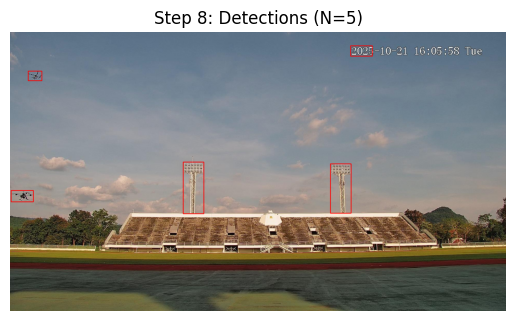

Detections: [(4, 613, 86, 44), (1240, 510, 80, 191), (670, 503, 80, 200), (70, 151, 53, 37), (1318, 53, 84, 40)]


In [ ]:
cnts, _ = cv2.findContours(cand, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

vis = rgb.copy()
boxes = []
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000:   # ปรับตามความละเอียดภาพ/ขนาดโดรนที่คาดหวัง
        continue
    x,y,w,h = cv2.boundingRect(c)

    boxes.append((x,y,w,h))
    cv2.rectangle(vis, (x,y), (x+w, y+h), (255,0,0), 2)

plt.imshow(vis); plt.axis('off'); plt.title(f"Step 8: Detections (N={len(boxes)})"); plt.show()
print("Detections:", boxes)
